# Decoupled Classifiers Case Study 2

This notebook will follow a similar approach to what was done in the notebook [Decoupled Classifiers Case Study 1](case_1.ipynb), but this time we'll use a real dataset. 

In [93]:
import sys
sys.path.append('../../../../notebooks')

import pandas as pd
import numpy as np
import random

from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from raimitigations.utils import split_data
import raimitigations.dataprocessing as dp
from raimitigations.cohort import DecoupledClass, CohortDefinition, CohortManager, fetch_cohort_results, plot_value_counts_cohort
from sklearn.pipeline import Pipeline
from download import download_datasets

SEED = 100

Load and split the data into train and test sets:

In [94]:
data_dir = "../../../../datasets/census/"
download_datasets(data_dir)

label_col = "income"
df_train = pd.read_csv(data_dir + "train.csv")
df_test = pd.read_csv(data_dir + "test.csv")
# convert to 0 and 1 encoding
df_train[label_col] = df_train[label_col].apply(lambda x: 0 if x == "<=50K" else 1)
df_test[label_col] = df_test[label_col].apply(lambda x: 0 if x == "<=50K" else 1)

X_train = df_train.drop(columns=[label_col])
y_train = df_train[label_col]
X_test = df_test.drop(columns=[label_col])
y_test = df_test[label_col]

df_train

,income,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country
0,0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,0,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,0,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,0,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States
32557,1,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States
32558,0,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States
32559,0,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States


In [95]:
def get_model():
    #model = DecisionTreeClassifier(max_features="sqrt")
    model = LGBMClassifier(random_state=SEED)
    return model

Taking a closer look at a few sensitive attributes of this dataset and possible imbalance in the data.

### The *"race"* cohorts

Let's start by plotting the label distribution over the "race" cohorts.

0    24720
1     7841
Name: income, dtype: int64

cohort_0 : (`race` == " Amer-Indian-Eskimo"):
0    275
1     36
Name: income, dtype: int64
***********

cohort_1 : (`race` == " Asian-Pac-Islander"):
0    763
1    276
Name: income, dtype: int64
***********

cohort_2 : (`race` == " Black"):
0    2737
1     387
Name: income, dtype: int64
***********

cohort_3 : (`race` == " Other"):
0    246
1     25
Name: income, dtype: int64
***********

cohort_4 : (`race` == " White"):
0    20699
1     7117
Name: income, dtype: int64
***********


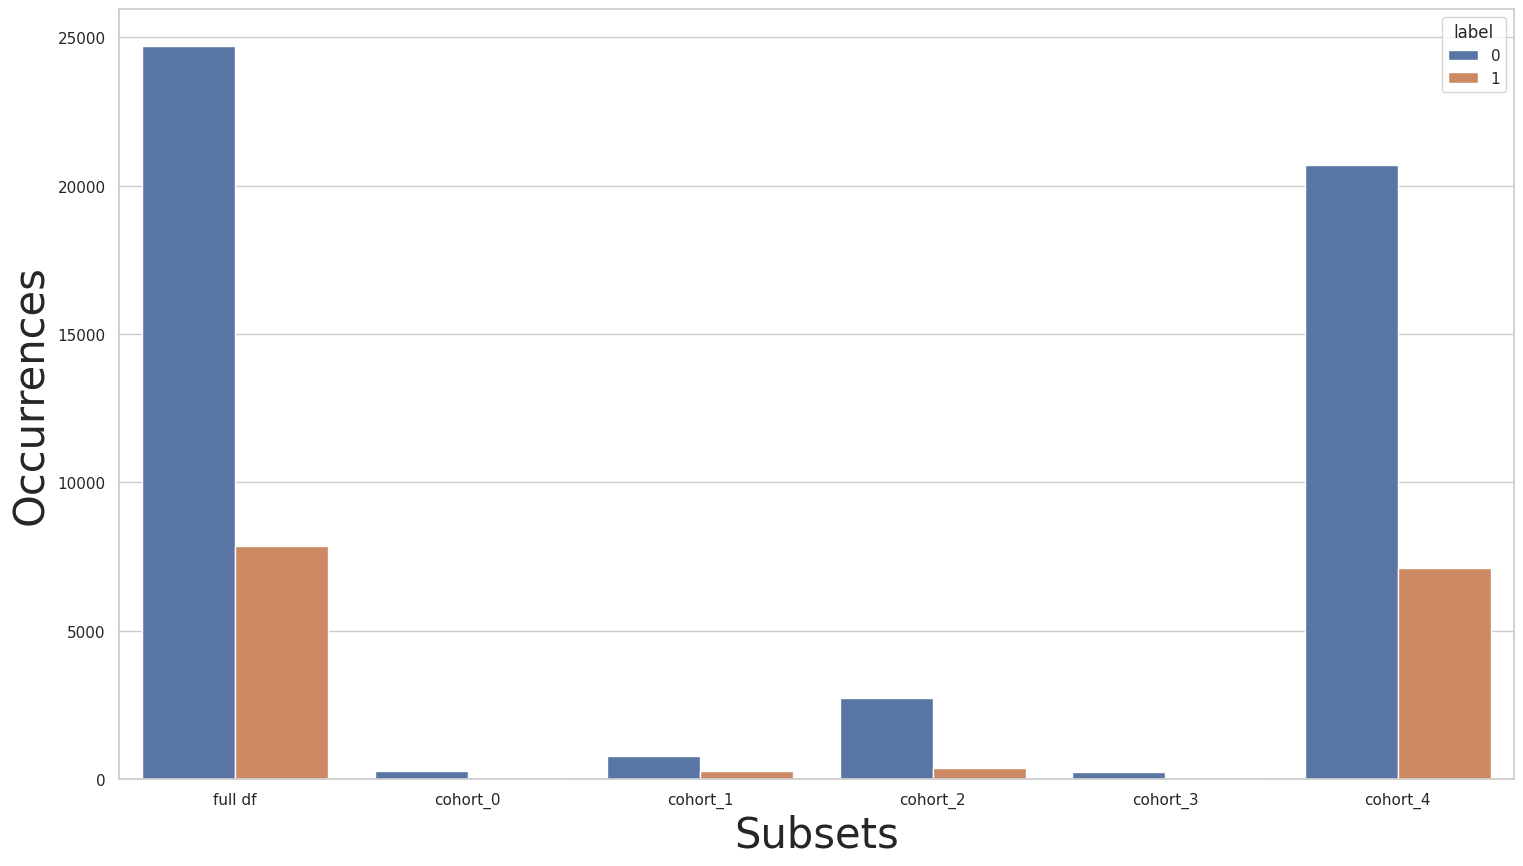

In [96]:
# BASELINE: "race"
cohort_set = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["race"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(X_train, y_train, apply_transform=False)

print(y_train.value_counts())

for key in subsets.keys():
    print(f"\n{key} : {cohort_set.get_queries()[key]}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(y_train, subsets, normalize=False)

Clearly, we can see an imbalance in the size of cohorts and label distribution. Given the sensitivity of the *"race"* attribute, merging cohorts might not be an appropriate solution, instead, let's take a look at the effect of transfer learning:

### Transfer Learning

**Note:** *the following experiment is expected to fail. We'll explain why it failed in the following cells*

In [97]:
preprocessing = [dp.DataStandardScaler(verbose=False), dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)]

dec_class = DecoupledClass(
    cohort_col=["race"],
    theta=True,
    min_fold_size_theta=15,
    min_cohort_pct=0.1,
    minority_min_rate=0.1,
    transform_pipe=preprocessing,
    estimator=get_model()
)
try:
    dec_class.fit(X_train, y_train)
except Exception as e:
    print(e)


INVALID COHORTS:
cohort_3:
	Size: 271
	Query:
		(`race` == " Other")
	Value Counts:
		0: 246 (90.77%)
		1: 25 (9.23%)
	Invalid: False
ERROR: Cannot use transfer learning over cohorts with skewed distributions.


The above code fails because one or more dataset has a label distribution invalidity, meaning that at least one cohort doesn't satisfy the minimum rate requirement of the minority class. In order to try and solve this skewed distribution, we can use the `Rebalance` functionality of this library to re-balance the data.

In [98]:
c0_pipe = [dp.Rebalance(strategy_over=0.5, verbose=False)]
c1_pipe = []
c2_pipe = []
c3_pipe = [dp.Rebalance(strategy_over=0.5, verbose=False)]
c4_pipe = []

cohort_set = CohortManager(
    transform_pipe=[c0_pipe, c1_pipe, c2_pipe, c3_pipe, c4_pipe],
    cohort_col=["race"]
)

rebalanced_X_train, rebalanced_y_train = cohort_set.fit_resample(X=X_train, y=y_train)

/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


let's look at the label distribution plots of the rebalanced data:

0    24720
1     8040
Name: income, dtype: int64

cohort_0 : (`race` == " Amer-Indian-Eskimo"):
0    275
1    137
Name: income, dtype: int64
***********

cohort_1 : (`race` == " Asian-Pac-Islander"):
0    763
1    276
Name: income, dtype: int64
***********

cohort_2 : (`race` == " Black"):
0    2737
1     387
Name: income, dtype: int64
***********

cohort_3 : (`race` == " Other"):
0    246
1    123
Name: income, dtype: int64
***********

cohort_4 : (`race` == " White"):
0    20699
1     7117
Name: income, dtype: int64
***********


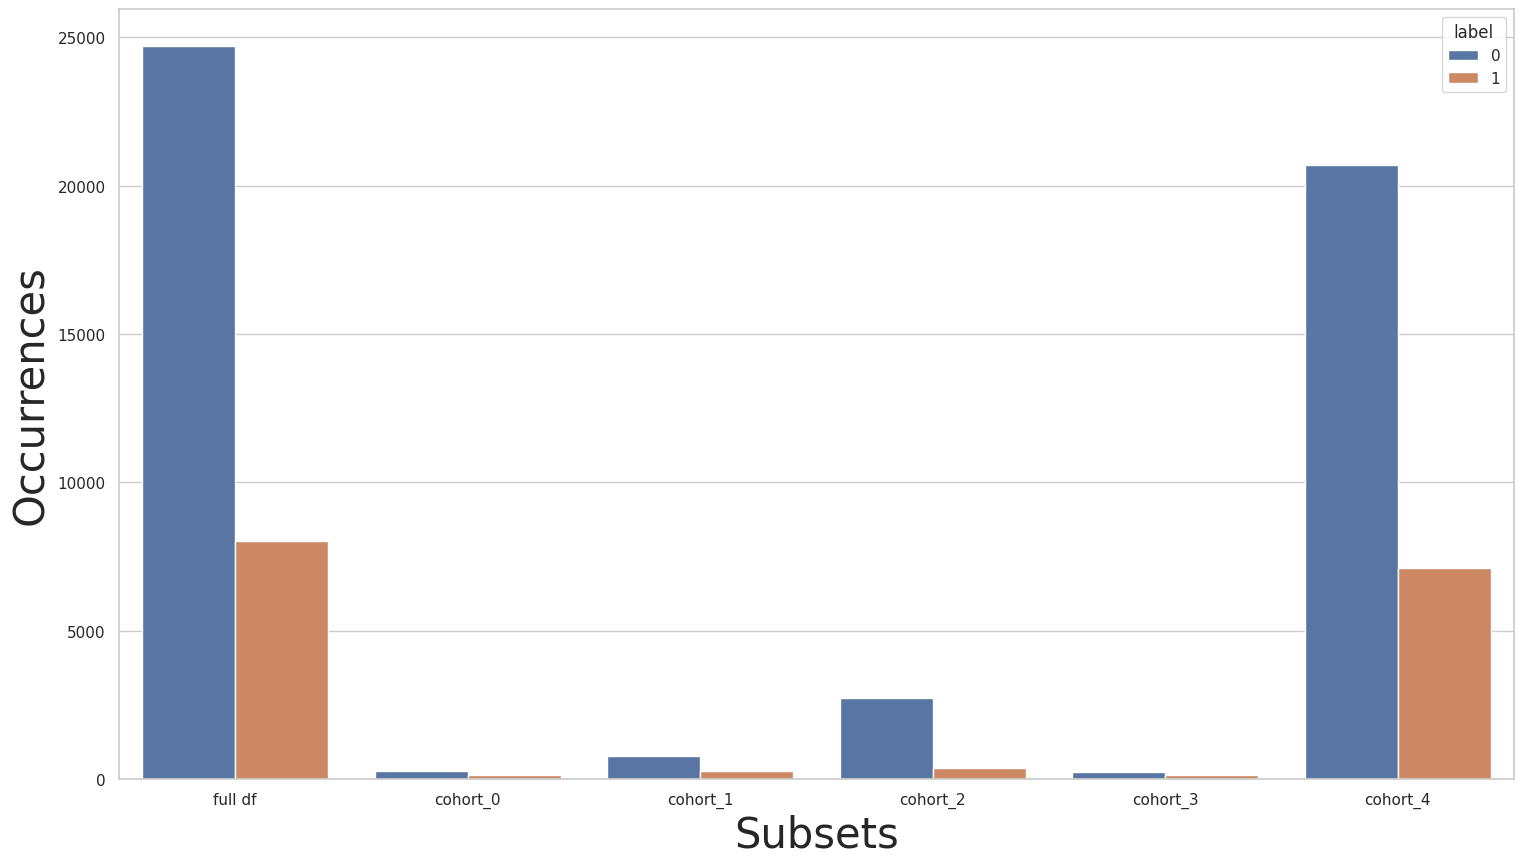

In [99]:
cohort_set = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["race"]
)
cohort_set.fit(X=rebalanced_X_train, y=rebalanced_y_train)
subsets = cohort_set.get_subsets(rebalanced_X_train, rebalanced_y_train, apply_transform=False)

print(rebalanced_y_train.value_counts())

for key in subsets.keys():
    print(f"\n{key} : {cohort_set.get_queries()[key]}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(rebalanced_y_train, subsets, normalize=False)


then the performance metrics of the rebalanced baseline cohorts:

In [100]:
pred_cht = cohort_set.predict_proba(X_test)

pred_train = cohort_set.predict_proba(rebalanced_X_train)
metrics_train, th_dict = fetch_cohort_results(rebalanced_X_train, rebalanced_y_train, pred_train, cohort_col=["race"], return_th_dict=True)
fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["race"], fixed_th=th_dict)

,cohort,cht_query,roc,precision,recall,f1,accuracy,threshold,num_pos,%_pos,cht_size
0,all,all,0.919891,0.779694,0.836502,0.798674,0.838585,0.260096,5186,0.318531,16281
1,cohort_0,"(`race` == "" Amer-Indian-Eskimo"")",0.719173,0.736372,0.594549,0.623024,0.886792,0.730358,7,0.044025,159
2,cohort_1,"(`race` == "" Asian-Pac-Islander"")",0.881606,0.795724,0.750569,0.767495,0.827083,0.522477,104,0.216667,480
3,cohort_2,"(`race` == "" Black"")",0.920955,0.771581,0.767609,0.769573,0.907111,0.367778,176,0.112748,1561
4,cohort_3,"(`race` == "" Other"")",0.906909,0.839147,0.595455,0.617357,0.844444,0.943149,6,0.044444,135
5,cohort_4,"(`race` == "" White"")",0.924379,0.780414,0.839327,0.797787,0.830346,0.254678,4860,0.348487,13946


And now let's attempt transfer learning again using the rebalanced data:

FINAL COHORTS
cohort_0:
	Size: 412
	Query:
		(`race` == " Amer-Indian-Eskimo")
	Value Counts:
		0: 275 (66.75%)
		1: 137 (33.25%)
	Invalid: True
		Cohorts used as outside data: ['cohort_1', 'cohort_2', 'cohort_3', 'cohort_4']
		Theta = 0.8


cohort_1:
	Size: 1039
	Query:
		(`race` == " Asian-Pac-Islander")
	Value Counts:
		0: 763 (73.44%)
		1: 276 (26.56%)
	Invalid: True
		Cohorts used as outside data: ['cohort_0', 'cohort_2', 'cohort_3', 'cohort_4']
		Theta = 0.8


cohort_2:
	Size: 3124
	Query:
		(`race` == " Black")
	Value Counts:
		0: 2737 (87.61%)
		1: 387 (12.39%)
	Invalid: True
		Cohorts used as outside data: ['cohort_0', 'cohort_1', 'cohort_3', 'cohort_4']
		Theta = 0.8


cohort_3:
	Size: 369
	Query:
		(`race` == " Other")
	Value Counts:
		0: 246 (66.67%)
		1: 123 (33.33%)
	Invalid: True
		Cohorts used as outside data: ['cohort_0', 'cohort_1', 'cohort_2', 'cohort_4']
		Theta = 0.8


cohort_4:
	Size: 27816
	Query:
		(`race` == " White")
	Value Counts:
		0: 20699 (74.41%)
		1: 711

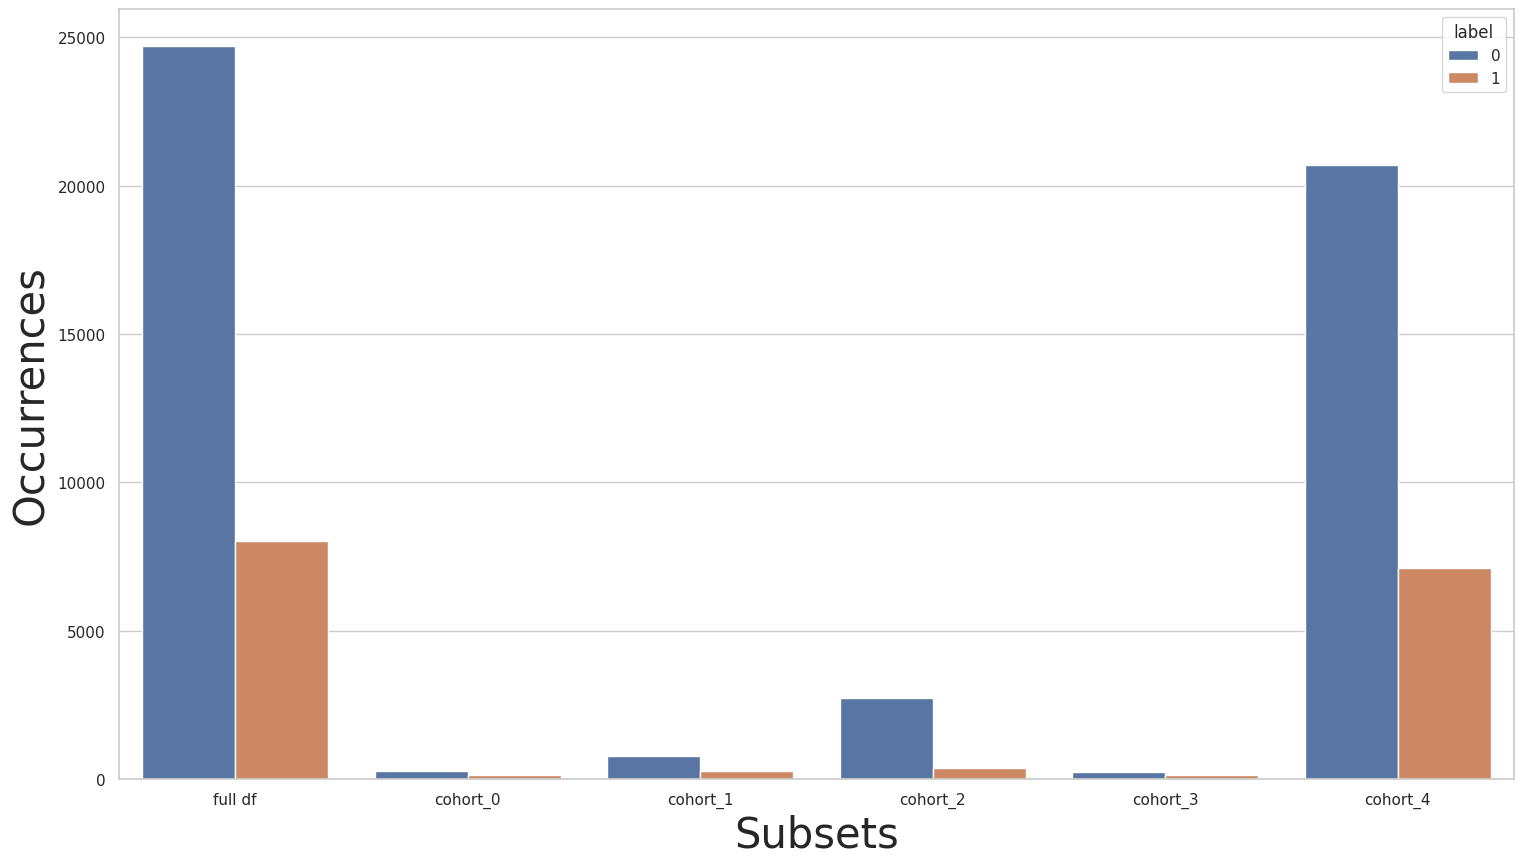

In [101]:
preprocessing = [dp.DataStandardScaler(verbose=False), dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)]

dec_class = DecoupledClass(
    cohort_col=["race"],
    theta=0.8,
    min_fold_size_theta=15,
    min_cohort_pct=0.1,
    minority_min_rate=0.1,
    transform_pipe=preprocessing,
    estimator=get_model()
)
dec_class.fit(rebalanced_X_train, rebalanced_y_train)

dec_class.print_cohorts()

subsets = dec_class.get_subsets(rebalanced_X_train, rebalanced_y_train, apply_transform=True)

print(rebalanced_y_train.value_counts())

for key in subsets.keys():
    print(f"\n{key} : {dec_class.get_queries()[key]}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(rebalanced_y_train, subsets, normalize=False)


In [102]:
th_dict = dec_class.get_threasholds_dict()
pred = dec_class.predict_proba(X_test)
fetch_cohort_results(X_test, y_test, pred, cohort_def=dec_class, fixed_th=th_dict)

,cohort,cht_query,roc,precision,recall,f1,accuracy,threshold,num_pos,%_pos,cht_size
0,all,all,0.927809,0.835215,0.799236,0.814789,0.873288,0.500000,3285,0.201769,16281
1,cohort_0,"(`race` == "" Amer-Indian-Eskimo"")",0.941729,0.799934,0.839850,0.817998,0.918239,0.406598,22,0.138365,159
2,cohort_1,"(`race` == "" Asian-Pac-Islander"")",0.905202,0.793487,0.802702,0.797815,0.835417,0.408684,140,0.291667,480
3,cohort_2,"(`race` == "" Black"")",0.950893,0.834517,0.809811,0.821497,0.930173,0.404750,164,0.105061,1561
4,cohort_3,"(`race` == "" Other"")",0.973455,0.877273,0.877273,0.877273,0.925926,0.395015,25,0.185185,135
5,cohort_4,"(`race` == "" White"")",0.924379,0.805904,0.820844,0.812812,0.856016,0.384067,3756,0.269325,13946


...thanks to the rebalance, we were able to run transfer learning over the *"race"* cohorts. 

It seems that transfer learning has a positive effect on most cohorts in the test set. We can see improvement in the ROC metric, label distribution and performance with a generally more comparable distribution among cohorts.

### The *"gender"* cohorts

Secondly, let's look at the plots and label distribution of another sensitive attribute:

0    24720
1     7841
Name: income, dtype: int64

cohort_0 : (`gender` == " Female"):
0    9592
1    1179
Name: income, dtype: int64
***********

cohort_1 : (`gender` == " Male"):
0    15128
1     6662
Name: income, dtype: int64
***********


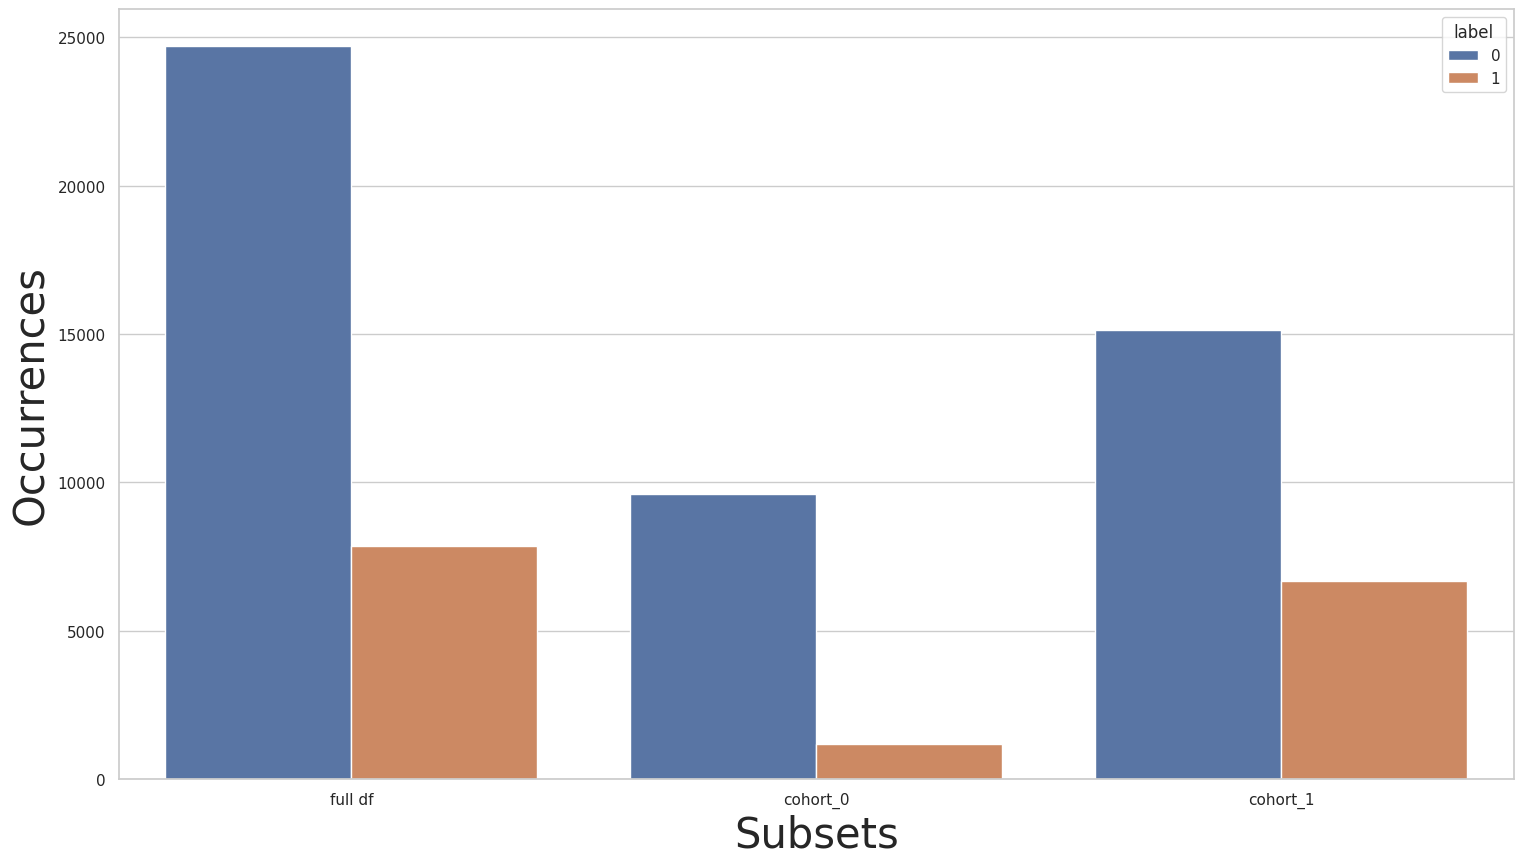

In [103]:
cohort_set = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["gender"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(X_train, y_train, apply_transform=False)

print(y_train.value_counts())

for key in subsets.keys():
    print(f"\n{key} : {cohort_set.get_queries()[key]}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(y_train, subsets, normalize=False)

In [104]:
pred_cht = cohort_set.predict_proba(X_test)

pred_train = cohort_set.predict_proba(X_train)
metrics_train, th_dict = fetch_cohort_results(X_train, y_train, pred_train, cohort_col=["gender"], return_th_dict=True)
fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["gender"], fixed_th=th_dict)


,cohort,cht_query,roc,precision,recall,f1,accuracy,threshold,num_pos,%_pos,cht_size
0,all,all,0.924731,0.775651,0.840135,0.794981,0.832750,0.243250,5447,0.334562,16281
1,cohort_0,"(`gender` == "" Female"")",0.939232,0.749313,0.854318,0.787376,0.899465,0.156009,895,0.165099,5421
2,cohort_1,"(`gender` == "" Male"")",0.908182,0.778074,0.818033,0.787847,0.806906,0.280206,4349,0.400460,10860


The distribution of the *"gender"* column might not be as skewed as the *"race"* column, but we can still see that cohort_1 has a more balanced distribution than cohort_0. Let's attempt to use transfer learning over these cohorts:

### Transfer Learning

In [105]:
preprocessing = [dp.DataStandardScaler(verbose=False), dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)]

dec_class = DecoupledClass(
    cohort_col=["gender"],
    theta=True,
    min_fold_size_theta=15,
    min_cohort_pct=0.1,
    minority_min_rate=0.1,
    transform_pipe=preprocessing,
    estimator=get_model()
)
dec_class.fit(X_train, y_train)

dec_class.print_cohorts()


FINAL COHORTS
cohort_0:
	Size: 10771
	Query:
		(`gender` == " Female")
	Value Counts:
		0: 9592 (89.05%)
		1: 1179 (10.95%)
	Invalid: False


cohort_1:
	Size: 21790
	Query:
		(`gender` == " Male")
	Value Counts:
		0: 15128 (69.43%)
		1: 6662 (30.57%)
	Invalid: False




In [106]:
th_dict = dec_class.get_threasholds_dict()
pred = dec_class.predict_proba(X_test)
fetch_cohort_results(X_test, y_test, pred, cohort_def=dec_class, fixed_th=th_dict)


,cohort,cht_query,roc,precision,recall,f1,accuracy,threshold,num_pos,%_pos,cht_size
0,all,all,0.924731,0.832133,0.794795,0.810810,0.870892,0.500000,3260,0.200233,16281
1,cohort_0,"(`gender` == "" Female"")",0.939232,0.814410,0.824649,0.819414,0.928795,0.341452,612,0.112894,5421
2,cohort_1,"(`gender` == "" Male"")",0.908182,0.791165,0.811141,0.799352,0.825414,0.365531,3690,0.339779,10860


In the case of the *"gender"* column, observing the two past results, we notice that transfer learning has improved the precision, F1 score, and accuracy for both cohorts. Therefore, transfer learning has proved useful in this scenario compared to using the more generic `CohortManager` approach.

### Fairness Optimization

One issue we can identify on the previous result is that the rate of positive labels for ``cohort_0`` is smaller than the positive rate in ``cohort_1``. In some cases, this is not desirable, as this shows that the model fitted has some bias in regard to the sensitive feature (in this case, the ``gender`` column). Let's try to mitigate this issue by using the DecoupledClass with Transfer Learning + Fairness optimization using the Demographic Parity loss.

In [107]:
preprocessing = [dp.DataStandardScaler(verbose=False), dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)]

dec_class = DecoupledClass(
    cohort_col=["gender"],
    theta=True,
    min_fold_size_theta=15,
    min_cohort_pct=0.1,
    minority_min_rate=0.1,
    transform_pipe=preprocessing,
    fairness_loss="dem_parity",
    lambda_coef=0.3,
    max_joint_loss_time=200,
    estimator=get_model()
)
dec_class.fit(X_train, y_train)

dec_class.print_cohorts()


FINAL COHORTS
cohort_0:
	Size: 10771
	Query:
		(`gender` == " Female")
	Value Counts:
		0: 9592 (89.05%)
		1: 1179 (10.95%)
	Invalid: False


cohort_1:
	Size: 21790
	Query:
		(`gender` == " Male")
	Value Counts:
		0: 15128 (69.43%)
		1: 6662 (30.57%)
	Invalid: False




In [108]:
th_dict = dec_class.get_threasholds_dict()
pred = dec_class.predict_proba(X_test)
fetch_cohort_results(X_test, y_test, pred, cohort_def=dec_class, fixed_th=th_dict)


,cohort,cht_query,roc,precision,recall,f1,accuracy,threshold,num_pos,%_pos,cht_size
0,all,all,0.924731,0.832133,0.794795,0.810810,0.870892,0.500000,3260,0.200233,16281
1,cohort_0,"(`gender` == "" Female"")",0.939232,0.643159,0.834692,0.643880,0.749124,0.023640,1884,0.347537,5421
2,cohort_1,"(`gender` == "" Male"")",0.908182,0.791165,0.811141,0.799352,0.825414,0.365531,3690,0.339779,10860


### The *"relationship"* cohorts

Lastly, we'll take a closer look at the relationship column, starting with the baseline:

0    24720
1     7841
Name: income, dtype: int64

cohort_0 : (`relationship` == " Husband"):
0    7275
1    5918
Name: income, dtype: int64
***********

cohort_1 : (`relationship` == " Not-in-family"):
0    7449
1     856
Name: income, dtype: int64
***********

cohort_2 : (`relationship` == " Other-relative"):
0    944
1     37
Name: income, dtype: int64
***********

cohort_3 : (`relationship` == " Own-child"):
0    5001
1      67
Name: income, dtype: int64
***********

cohort_4 : (`relationship` == " Unmarried"):
0    3228
1     218
Name: income, dtype: int64
***********

cohort_5 : (`relationship` == " Wife"):
0    823
1    745
Name: income, dtype: int64
***********


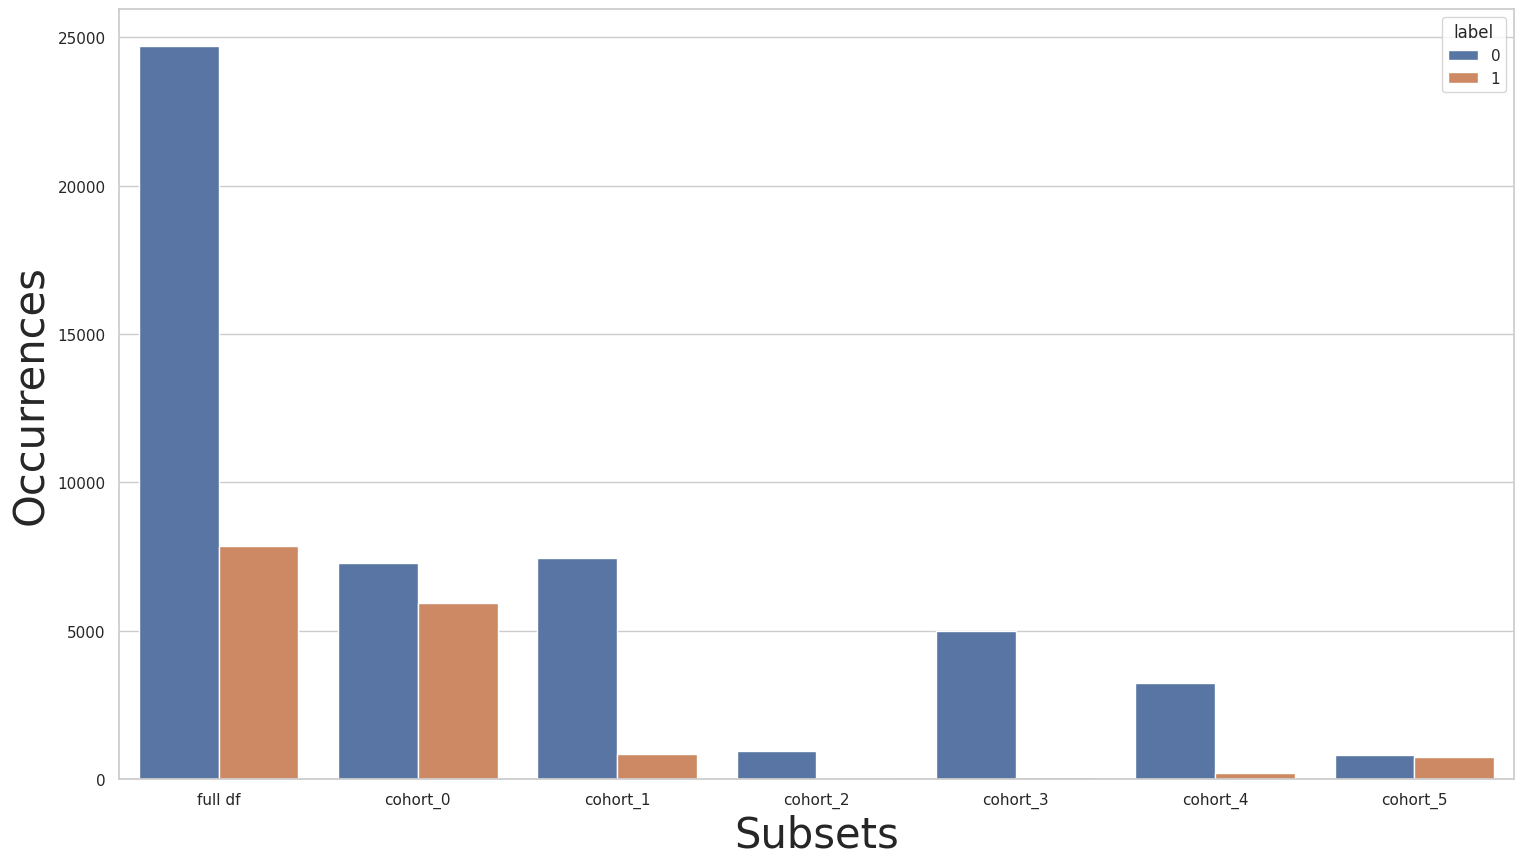

In [82]:
cohort_set = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["relationship"]
)
cohort_set.fit(X=X_train, y=y_train)
subsets = cohort_set.get_subsets(X_train, y_train, apply_transform=False)

print(y_train.value_counts())

for key in subsets.keys():
    print(f"\n{key} : {cohort_set.get_queries()[key]}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(y_train, subsets, normalize=False)


similar to the *"race"* column, we can see that some cohorts are smaller and with more skewness in label distribution than others. Can we apply transfer learning in this case?

### Transfer Learning

In [83]:
preprocessing = [dp.DataStandardScaler(verbose=False), dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)]

dec_class = DecoupledClass(
    cohort_col=["relationship"],
    theta=True,
    min_fold_size_theta=15,
    min_cohort_pct=0.1,
    minority_min_rate=0.1,
    transform_pipe=preprocessing,
    estimator=get_model()
)
try:
    dec_class.fit(X_train, y_train)
except Exception as e:
    print(e)


INVALID COHORTS:
cohort_2:
	Size: 981
	Query:
		(`relationship` == " Other-relative")
	Value Counts:
		0: 944 (96.23%)
		1: 37 (3.77%)
	Invalid: False
cohort_3:
	Size: 5068
	Query:
		(`relationship` == " Own-child")
	Value Counts:
		0: 5001 (98.68%)
		1: 67 (1.32%)
	Invalid: False
cohort_4:
	Size: 3446
	Query:
		(`relationship` == " Unmarried")
	Value Counts:
		0: 3228 (93.67%)
		1: 218 (6.33%)
	Invalid: False
ERROR: Cannot use transfer learning over cohorts with skewed distributions.


Similar to the *"race"* column, we are unable to directly apply transfer learning over these cohorts, so we will rebalance the training data first:

In [84]:
c0_pipe = []
c1_pipe = [dp.Rebalance(strategy_over='minority', verbose=False)]
c2_pipe = [dp.Rebalance(strategy_over='minority', verbose=False)]
c3_pipe = [dp.Rebalance(strategy_over='minority', verbose=False)]
c4_pipe = [dp.Rebalance(strategy_over='minority', verbose=False)]
c5_pipe = []

cohort_set = CohortManager(
    transform_pipe=[c0_pipe, c1_pipe, c2_pipe, c3_pipe, c4_pipe, c5_pipe],
    cohort_col=["relationship"]
)

rebalanced_X_train, rebalanced_y_train = cohort_set.fit_resample(X=X_train, y=y_train)

/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mmendonca/anaconda3/envs/raipub/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:808: Future

Now let's run the baseline plots again:

0    24720
1    23285
Name: income, dtype: int64

cohort_0 : (`relationship` == " Husband"):
0    7275
1    5918
Name: income, dtype: int64
***********

cohort_1 : (`relationship` == " Not-in-family"):
0    7449
1    7449
Name: income, dtype: int64
***********

cohort_2 : (`relationship` == " Other-relative"):
0    944
1    944
Name: income, dtype: int64
***********

cohort_3 : (`relationship` == " Own-child"):
0    5001
1    5001
Name: income, dtype: int64
***********

cohort_4 : (`relationship` == " Unmarried"):
0    3228
1    3228
Name: income, dtype: int64
***********

cohort_5 : (`relationship` == " Wife"):
0    823
1    745
Name: income, dtype: int64
***********


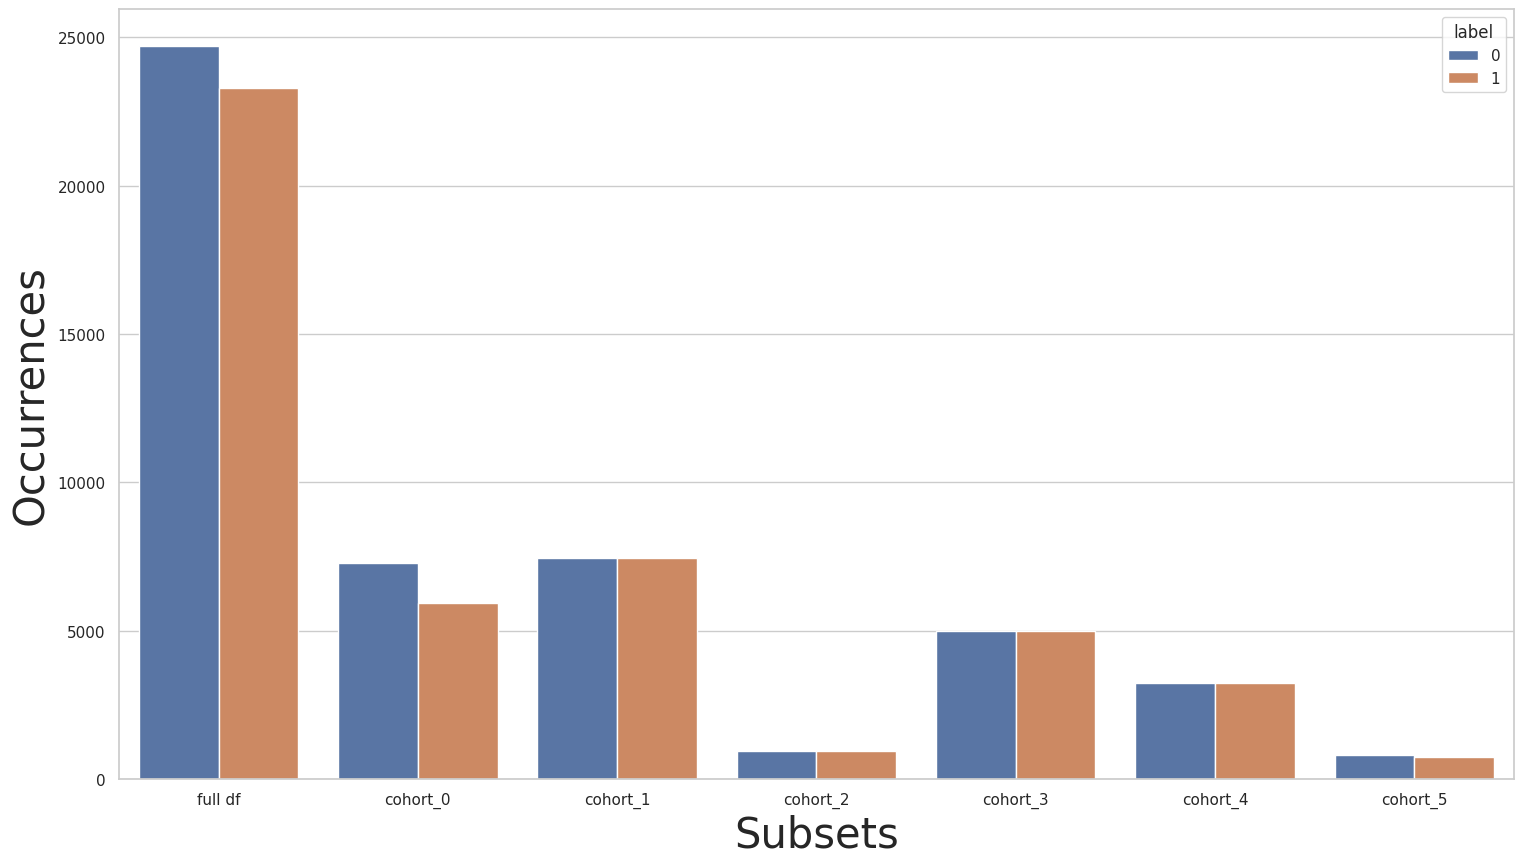

In [85]:
cohort_set = CohortManager(
    transform_pipe=[
        dp.DataStandardScaler(verbose=False),
        dp.EncoderOHE(drop=False, unknown_err=False, verbose=False),
        get_model()
    ],
    cohort_col=["relationship"]
)
cohort_set.fit(X=rebalanced_X_train, y=rebalanced_y_train)
subsets = cohort_set.get_subsets(rebalanced_X_train, rebalanced_y_train, apply_transform=False)

print(rebalanced_y_train.value_counts())

for key in subsets.keys():
    print(f"\n{key} : {cohort_set.get_queries()[key]}:\n{subsets[key]['y'].value_counts()}\n***********")

plot_value_counts_cohort(rebalanced_y_train, subsets, normalize=False)


In [86]:
pred_cht = cohort_set.predict_proba(X_test)

pred_train = cohort_set.predict_proba(rebalanced_X_train)
metrics_train, th_dict = fetch_cohort_results(rebalanced_X_train, rebalanced_y_train, pred_train, cohort_col=["relationship"], return_th_dict=True)
fetch_cohort_results(X_test, y_test, pred_cht, cohort_col=["relationship"], fixed_th=th_dict)

,cohort,cht_query,roc,precision,recall,f1,accuracy,threshold,num_pos,%_pos,cht_size
0,all,all,0.913161,0.799514,0.797840,0.798671,0.855107,0.469123,3815,0.234322,16281
1,cohort_0,"(`relationship` == "" Husband"")",0.847310,0.763712,0.760496,0.761651,0.765445,0.467993,2772,0.424958,6523
2,cohort_1,"(`relationship` == "" Not-in-family"")",0.886510,0.745795,0.738989,0.742325,0.910005,0.535268,407,0.095138,4278
3,cohort_2,"(`relationship` == "" Other-relative"")",0.905359,0.822736,0.631373,0.684159,0.975238,0.947751,6,0.011429,525
4,cohort_3,"(`relationship` == "" Own-child"")",0.907388,0.706046,0.710644,0.708318,0.979706,0.631069,45,0.017907,2513
5,cohort_4,"(`relationship` == "" Unmarried"")",0.882609,0.677055,0.709674,0.691634,0.930911,0.529153,109,0.064920,1679
6,cohort_5,"(`relationship` == "" Wife"")",0.830681,0.734595,0.735099,0.734815,0.736566,0.510850,353,0.462647,763


And lastly let's reattempt transfer learning and compare its metrics to the baseline:

In [89]:
preprocessing = [dp.DataStandardScaler(verbose=False), dp.EncoderOHE(drop=False, unknown_err=False, verbose=False)]

dec_class = DecoupledClass(
    cohort_col=["relationship"],
    theta=True,
    min_fold_size_theta=15,
    min_cohort_pct=0.1,
    minority_min_rate=0.1,
    transform_pipe=preprocessing,
    estimator=get_model()
)
dec_class.fit(rebalanced_X_train, rebalanced_y_train)

dec_class.print_cohorts()

FINAL COHORTS
cohort_0:
	Size: 13193
	Query:
		(`relationship` == " Husband")
	Value Counts:
		0: 7275 (55.14%)
		1: 5918 (44.86%)
	Invalid: False


cohort_1:
	Size: 14898
	Query:
		(`relationship` == " Not-in-family")
	Value Counts:
		0: 7449 (50.00%)
		1: 7449 (50.00%)
	Invalid: False


cohort_2:
	Size: 1888
	Query:
		(`relationship` == " Other-relative")
	Value Counts:
		0: 944 (50.00%)
		1: 944 (50.00%)
	Invalid: True
		Cohorts used as outside data: ['cohort_0', 'cohort_1', 'cohort_3', 'cohort_4', 'cohort_5']
		Theta = 0.2


cohort_3:
	Size: 10002
	Query:
		(`relationship` == " Own-child")
	Value Counts:
		0: 5001 (50.00%)
		1: 5001 (50.00%)
	Invalid: False


cohort_4:
	Size: 6456
	Query:
		(`relationship` == " Unmarried")
	Value Counts:
		0: 3228 (50.00%)
		1: 3228 (50.00%)
	Invalid: False


cohort_5:
	Size: 1568
	Query:
		(`relationship` == " Wife")
	Value Counts:
		0: 823 (52.49%)
		1: 745 (47.51%)
	Invalid: True
		Cohorts used as outside data: ['cohort_0', 'cohort_1', 'cohort_2

In [90]:
th_dict = dec_class.get_threasholds_dict()
pred = dec_class.predict_proba(X_test)
fetch_cohort_results(X_test, y_test, pred, cohort_def=dec_class, fixed_th=th_dict)

,cohort,cht_query,roc,precision,recall,f1,accuracy,threshold,num_pos,%_pos,cht_size
0,all,all,0.914236,0.809129,0.795081,0.801682,0.860082,0.500000,3600,0.221117,16281
1,cohort_0,"(`relationship` == "" Husband"")",0.847310,0.746642,0.748831,0.743895,0.744136,0.367500,3395,0.520466,6523
2,cohort_1,"(`relationship` == "" Not-in-family"")",0.886510,0.710561,0.753516,0.729050,0.894109,0.444907,519,0.121318,4278
3,cohort_2,"(`relationship` == "" Other-relative"")",0.940261,0.746024,0.855882,0.789894,0.971429,0.506925,22,0.041905,525
4,cohort_3,"(`relationship` == "" Own-child"")",0.907388,0.692846,0.710036,0.701050,0.978512,0.607914,48,0.019101,2513
5,cohort_4,"(`relationship` == "" Unmarried"")",0.882609,0.677055,0.709674,0.691634,0.930911,0.529153,109,0.064920,1679
6,cohort_5,"(`relationship` == "" Wife"")",0.865590,0.780855,0.782139,0.781301,0.782438,0.491991,360,0.471822,763


In this case, transfer learning hasn't made a noticeable difference over the cohorts of the training data since the rebalancig has already done most of the heavy lifting to even out the distribution. As for its performance over the test set cohorts, we can see improvement in the label distribution and accuracy of some cohorts, but it is small.